In [16]:
import numpy as np
import pandas as pd
import json
import random
import onnxruntime
from onnx2torch import convert
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import nn
import onnx
from IPython.display import display, HTML
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'serif'})
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from tqdm.notebook import tqdm
from tqdm import trange
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
print(torch.cuda.device_count())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

1


device(type='cuda')

Load the system model data

In [4]:
# Load the JSON file
print("Testing 123")
with open('CALTECH_ONNX_Model/model.json', 'r') as f:
    json_data = json.load(f)

# I/O labels
input_labels = [json_data['inputs'][i]['id']
                for i in range(len(json_data['inputs']))]
output_labels = [json_data['outputs'][i]['id']
                 for i in range(len(json_data['outputs']))]

# Upper and lower bounds on inputs
lower_bound = [json_data['inputs'][i]['min']
               for i in range(len(json_data['inputs']))]
upper_bound = [json_data['inputs'][i]['max']
               for i in range(len(json_data['inputs']))]

# Other spec
unit = [json_data['inputs'][i]['unit']
        for i in range(len(json_data['inputs']))]
data_type = [json_data['inputs'][i]['data_type']
             for i in range(len(json_data['inputs']))]

inputs_table = pd.DataFrame({'Label': input_labels, 'unit': unit,
                            'data type': data_type, 'min': lower_bound, 'max': upper_bound})
inputs_table = inputs_table.set_index('Label')

# change 'min' for GT1_PWR, GT2_PWR, GT3_PWR, ST_PWR to be 0
# this is a simplification that ensures we can always ramp down to zero if there's no energy demand
inputs_table.loc['GT1_PWR', 'min'] = 0
inputs_table.loc['GT2_PWR', 'min'] = 0
inputs_table.loc['GT3_PWR', 'min'] = 0
inputs_table.loc['ST_PWR', 'min'] = 0
display(inputs_table)
max_generation = (inputs_table.loc['GT1_PWR', 'max'] + inputs_table.loc['GT2_PWR', 'max'] + inputs_table.loc['GT3_PWR', 'max'] + inputs_table.loc['ST_PWR', 'max'])

Testing 123


,unit,data type,min,max
Label,,,,
TAMB,°F,float,32.000345,114.999663
PAMB,psia,float,14.000005,14.999995
RHAMB,-,float,0.000004,0.999994
GT1_PAC_FFU,nan,bool,0.000000,1.000000
GT1_EVC_FFU,nan,bool,0.000000,1.000000
GT1_PWR,MW,float,0.000000,168.266991
GT2_PAC_FFU,nan,bool,0.000000,1.000000
GT2_EVC_FFU,nan,bool,0.000000,1.000000
GT2_PWR,MW,float,0.000000,168.413644


In [5]:
# Generating a random input

# Initialization
input_data = np.zeros(18)

# Loop through the rows of the table and generate a random variable for each
for i, (_, row) in enumerate(inputs_table.iterrows()):
    # Generate a random variable based on the data type
    if row['data type'] == 'int':
        input_data[i] = random.randint(row['min'], row['max'])
    elif row['data type'] == 'float':
        input_data[i] = random.uniform(row['min'], row['max'])
    elif row['data type'] == 'bool':
        input_data[i] = random.choice([0, 1])

# Print the variable name and the random variable
print(input_data)

[ 7.29895250e+01  1.43368862e+01  5.56156820e-02  1.00000000e+00
  1.00000000e+00  2.06740343e+01  0.00000000e+00  0.00000000e+00
  1.09877813e+02  1.00000000e+00  0.00000000e+00  8.10702327e+01
  5.13087449e+02  8.14243442e+02  7.80511149e+02  2.11963137e+01
 -4.44764504e+02  4.00000000e+00]


Construct/load the ambient conditions dataframes for each wind condition

In [6]:
from util import construct_df

# cap the max energy demand at max generation - 10 to ensure there's always 
# a non-singleton set of feasible dispatches
dfs_wind0 = construct_df(renewables_magnitude=0, max_demand=max_generation - 10)
dfs_wind100 = construct_df(renewables_magnitude=100, max_demand=max_generation - 10)
dfs_wind200 = construct_df(renewables_magnitude=200, max_demand=max_generation - 10)
dfs_wind300 = construct_df(renewables_magnitude=300, max_demand=max_generation - 10)
dfs_wind400 = construct_df(renewables_magnitude=400, max_demand=max_generation - 10)

Load the system model

In [7]:
# Load the ONNX model
session = onnxruntime.InferenceSession('CALTECH_ONNX_Model/model.onnx')
onnx_model = onnx.load("CALTECH_ONNX_Model/model.onnx")
system_model_pytorch = convert(onnx_model)
system_model_pytorch.to(device).double()


def system_model(input_data):
    return session.run(None, {session.get_inputs()[0].name: [input_data]})[0][0]


input_datas = [np.concatenate(([x], input_data[1:]))
               for x in np.linspace(0, 1, 100)]
# Run the model on the generated random input
output_datas = [session.run(None, {session.get_inputs()[0].name: [
                            input_datas[i]]}) for i in range(100)]
# output_data = system_model(torch.tensor(input_data, dtype=torch.float32, device=device).unsqueeze(0))

Define the system cost functions (including fuel, ramp, constraint violation, etc.)

In [8]:
def operating_constraint_volation(input_batch, output_batch):
    """Computes the constraint violation for each batch in the input batch"""
    # batch_size = input_batch.shape[0]
    tzero = 0
    cv = np.zeros(16)

    # GT1_PWR
    cv[0] = np.maximum(
        tzero, output_batch[9] - input_batch[5])  # min violation
    cv[1] = np.maximum(tzero, input_batch[5] -
                       output_batch[10])  # max violation
    # GT1_HR
    cv[2] = np.maximum(
        tzero, output_batch[15] - input_batch[12])  # min violation
    cv[3] = np.maximum(
        tzero, input_batch[12] - output_batch[16])  # max violation

    # GT2_PWR
    cv[4] = np.maximum(
        tzero, output_batch[11] - input_batch[8])  # min violation
    cv[5] = np.maximum(tzero, input_batch[8] -
                       output_batch[12])  # max violation
    # GT2_HR
    cv[6] = np.maximum(
        tzero, output_batch[17] - input_batch[13])  # min violation
    cv[7] = np.maximum(
        tzero, input_batch[13] - output_batch[18])  # max violation

    # GT3_PWR
    cv[8] = np.maximum(
        tzero, output_batch[13] - input_batch[11])  # min violation
    cv[9] = np.maximum(
        tzero, input_batch[11] - output_batch[14])  # max violation
    # GT3_HR
    cv[10] = np.maximum(
        tzero, output_batch[19] - input_batch[14])  # min violation
    cv[11] = np.maximum(
        tzero, input_batch[14] - output_batch[20])  # max violation

    # ST_PWR
    cv[12] = np.maximum(
        tzero, output_batch[24] - input_batch[15])  # min violation
    cv[13] = np.maximum(
        tzero, input_batch[15] - output_batch[25])  # max violation
    # IPPROC
    cv[14] = np.maximum(
        tzero, input_batch[16] - output_batch[22])  # max violation
    cv[15] = np.maximum(
        tzero, input_batch[16] - output_batch[23])  # max violation

    return cv


def constr_violation_2(input_batch, output_batch, ambients_batch):
    """
    Computes the capacity limits and steam supply-demand imbalance
    constraint violation
    """
    # energy supply-demand balance
    # note we ignore the auxiliary power consumption of the plant,
    # so that we can enforce the constraint on the energy dispatch
    energy_sd_constr_violation = np.abs(
        output_batch[-2] + output_batch[-3] - ambients_batch[3])
    # steam supply-demand balance
    steam_sd_constr_violation = np.abs(
        output_batch[-1] - ambients_batch[4])
    return energy_sd_constr_violation, steam_sd_constr_violation


def constr_violation_2_pytorch(input_batch, output_batch, ambients_batch):
    """
    Computes the capacity limits and steam supply-demand imbalance
    constraint violation
    """
    # energy supply-demand balance
    # note we ignore the auxiliary power consumption of the plant,
    # so that we can enforce the constraint on the energy dispatch
    energy_sd_constr_violation = torch.abs(
        output_batch[:, -2] + output_batch[:, -3] - ambients_batch[:, 3])
    # steam supply-demand balance
    steam_sd_constr_violation = torch.abs(
        output_batch[:, -1] - ambients_batch[:, 4])
    return energy_sd_constr_violation, steam_sd_constr_violation


def fuel_consumption(dispatch_batch, ambients_batch, penalty=1e2):
    """
    Computes the fuel consumption for each dispatch in the input batch
    Assume each entry in the ambients batch is of the form:
    (temperature, pressure, relative humidity, energy demand, steam demand)
    and dispatch batch is in the right order to be concatenated

    Also includes all constraint violations in the loss function, including
    both supply-demand balance and dynamic limits
    """

    aug_inputs = np.hstack([ambients_batch[:3], dispatch_batch])
    plant_outputs = system_model(aug_inputs)
    # select just the fuel consumption to output as cost
    fuel_consumption = plant_outputs[-8]
    # compute the supply-demand constraint violation
    sd_constr_violation_0 = constr_violation_2(
        dispatch_batch, plant_outputs, ambients_batch)
    sd_constr_violation_1 = sd_constr_violation_0[0] + sd_constr_violation_0[1]
    # compute the dynamic constraint violation
    # ignoring this term for the current model
    # dyn_constr_violation = operating_constraint_volation(
    # aug_inputs, plant_outputs).sum()
    dyn_constr_violation = 0
    # return both penalized cost + total penalty
    return fuel_consumption + penalty * (sd_constr_violation_1 + dyn_constr_violation)


def fuel_consumption_pytorch(dispatch_batch, ambients_batch, penalty=1e2):
    """
    Computes the fuel consumption for each dispatch in the input batch
    Assume each entry in the ambients batch is of the form:
    (temperature, pressure, relative humidity, energy demand, steam demand)
    and dispatch batch is in the right order to be concatenated

    Also includes all constraint violations in the loss function, including
    both supply-demand balance and dynamic limits
    """
    aug_inputs = torch.hstack([ambients_batch[:, :3], dispatch_batch])
    plant_outputs = system_model_pytorch(aug_inputs)
    # select just the fuel consumption to output
    fuel_consumption = plant_outputs[:, -8]
    # compute the supply-demand constraint violation
    # compute the supply-demand constraint violation
    sd_constr_violation_0 = constr_violation_2_pytorch(
        dispatch_batch, plant_outputs, ambients_batch)
    sd_constr_violation_1 = sd_constr_violation_0[0] + sd_constr_violation_0[1]
    # compute the dynamic constraint violation
    dyn_constr_violation = 0
    # return both penalized cost + total penalty
    return fuel_consumption + penalty * (sd_constr_violation_1 + dyn_constr_violation)


def ramp_cost(dispatch_1, dispatch_2, penalty=10):
    """
    Computes the ramp cost between two dispatches
    Only penalize entries 2, 5, 8, 12 (the energy dispatch entries)
    """
    ramp_cost = penalty * (np.abs(dispatch_1[2] - dispatch_2[2])
                           + np.abs(dispatch_1[5] - dispatch_2[5])
                           + np.abs(dispatch_1[8] - dispatch_2[8])
                           + np.abs(dispatch_1[12] - dispatch_2[12]))
    return ramp_cost


def ramp_cost_pytorch(dispatch_1, dispatch_2, penalty=10):
    """
    Computes the ramp cost between two dispatches
    Only penalize entries 2, 5, 8, 12 (the energy dispatch entries)
    """
    ramp_cost = penalty * (torch.abs(dispatch_1[:, 2] - dispatch_2[:, 2])
                           + torch.abs(dispatch_1[:, 5] - dispatch_2[:, 5])
                           + torch.abs(dispatch_1[:, 8] - dispatch_2[:, 8])
                           + torch.abs(dispatch_1[:, 12] - dispatch_2[:, 12]))
    return ramp_cost


def lookahead_cost(dispatch_decisions, ambient_conditions, lookahead_horizon=6, ramp_penalty=10, penalty=1e2):
    """ 
    Computes the cost over a lookahead horizon
    """
    cost = fuel_consumption(
        dispatch_decisions[0], ambient_conditions[0], penalty=penalty)
    for i in range(lookahead_horizon):
        cost += fuel_consumption(dispatch_decisions[i+1],
                                 ambient_conditions[i+1], penalty=penalty)
        cost += ramp_cost(dispatch_decisions[i],
                          dispatch_decisions[i+1], penalty=ramp_penalty)
    return cost


def lookahead_cost_pytorch(dispatch_decisions, ambient_conditions, lookahead_horizon=6, ramp_penalty=10, penalty=1e2):
    """ 
    Computes the cost over a lookahead horizon
    """
    cost = fuel_consumption_pytorch(
        dispatch_decisions[:, 0], ambient_conditions[:, 0], penalty=penalty)
    for i in range(lookahead_horizon):
        cost += fuel_consumption_pytorch(dispatch_decisions[:, i+1],
                                         ambient_conditions[:, i+1], penalty=penalty)
        cost += ramp_cost_pytorch(dispatch_decisions[:, i],
                                  dispatch_decisions[:, i+1], penalty=ramp_penalty)
    return cost


def reduced_lookahead_cost(dispatch_decisions, ambient_conditions, lookahead_horizon=6, ramp_penalty=10, penalty=1e2):
    """ 
    Computes the cost over a lookahead horizon
    Assume that the only decision variables are GT1_PWR, GT2_PWR, GT3_PWR, 
    HR1_HPIP_M_PROC, HR2_HPIP_M_PROC, HR3_HPIP_M_PROC, ST_PWR, IPPROC_M
    (energy and steam variables)
    fill in the rest of the variables with 0 (for switches) and 12 (for # cooling bays)
    # note dispatch_decisions has shape 8 x (lookahead_horizon + 1)
    """
    dispatch_template = np.zeros((lookahead_horizon+1, 15))
    dispatch_template[:, 2] = dispatch_decisions[:, 0]  # GT1_PWR
    dispatch_template[:, 5] = dispatch_decisions[:, 1]  # GT2_PWR
    dispatch_template[:, 8] = dispatch_decisions[:, 2]  # GT3_PWR
    dispatch_template[:, 9] = dispatch_decisions[:, 3]  # HR1_HPIP_M_PROC
    dispatch_template[:, 10] = dispatch_decisions[:, 4]  # HR2_HPIP_M_PROC
    dispatch_template[:, 11] = dispatch_decisions[:, 5]  # HR3_HPIP_M_PROC
    dispatch_template[:, 12] = dispatch_decisions[:, 6]  # ST_PWR
    dispatch_template[:, 13] = dispatch_decisions[:, 7]  # IPPROC_M
    dispatch_template[:, 14] = 12
    return lookahead_cost(dispatch_template, ambient_conditions, lookahead_horizon=lookahead_horizon, ramp_penalty=ramp_penalty, penalty=penalty)


def reduced_lookahead_cost_pytorch(dispatch_decisions, ambient_conditions, lookahead_horizon=6, ramp_penalty=10, penalty=1e2):
    """ 
    Computes the cost over a lookahead horizon
    Assume that the only decision variables are GT1_PWR, GT2_PWR, GT3_PWR, 
    HR1_HPIP_M_PROC, HR2_HPIP_M_PROC, HR3_HPIP_M_PROC, ST_PWR, IPPROC_M
    (energy and steam variables)
    fill in the rest of the variables with 0 (for switches) and 12 (for # cooling bays)
    # note dispatch_decisions has shape 8 x (lookahead_horizon + 1)
    """
    batch_size = dispatch_decisions.shape[0]
    dispatch_template = torch.zeros(
        (batch_size, lookahead_horizon+1, 15), device=device)
    dispatch_template[:, :, 2] = dispatch_decisions[:, :, 0]  # GT1_PWR
    dispatch_template[:, :, 5] = dispatch_decisions[:, :, 1]  # GT2_PWR
    dispatch_template[:, :, 8] = dispatch_decisions[:, :, 2]  # GT3_PWR
    dispatch_template[:, :, 9] = dispatch_decisions[:, :, 3]  # HR1_HPIP_M_PROC
    dispatch_template[:, :, 10] = dispatch_decisions[:, :, 4] # HR2_HPIP_M_PROC
    dispatch_template[:, :, 11] = dispatch_decisions[:, :, 5] # HR3_HPIP_M_PROC
    dispatch_template[:, :, 12] = dispatch_decisions[:, :, 6]  # ST_PWR
    dispatch_template[:, :, 13] = dispatch_decisions[:, :, 7]  # IPPROC_M
    dispatch_template[:, :, 14] = 12
    return lookahead_cost_pytorch(dispatch_template, ambient_conditions, lookahead_horizon=lookahead_horizon, ramp_penalty=ramp_penalty, penalty=penalty)

def reduced_one_step_cost(xt, xtmin1, ambient_conditions, ramp_penalty, penalty):
    """
    Computes the cost for a single time step of ramping from the previous decision + the current fuel cost
    """
    dispatch_template = np.zeros(15)
    dispatch_template[2] = xt[0]  # GT1_PWR
    dispatch_template[5] = xt[1]  # GT2_PWR
    dispatch_template[8] = xt[2]  # GT3_PWR
    dispatch_template[9] = xt[3]  # HR1_HPIP_M_PROC
    dispatch_template[10] = xt[4]  # HR2_HPIP_M_PROC
    dispatch_template[11] = xt[5]  # HR3_HPIP_M_PROC
    dispatch_template[12] = xt[6]  # ST_PWR
    dispatch_template[13] = xt[7]  # IPPROC_M
    dispatch_template[14] = 12
    ramp_cost = (np.abs(xt[0] - xtmin1[0]) 
                 + np.abs(xt[1] - xtmin1[1]) 
                 + np.abs(xt[2] - xtmin1[2]) 
                 + np.abs(xt[6] - xtmin1[6]))
    return fuel_consumption(dispatch_template, ambient_conditions, penalty=penalty) + ramp_penalty * ramp_cost


Restructure the ambient conditions dataframes to prepare for solving the dispatch problems and, later on, training the ML model

In [9]:
# converts the dfs data into a form that is amenable to training
# columns in the following order:
# (temperature, pressure, relative humidity, energy demand, steam demand, energy price, gas price)
def df_to_stack(df):
    return df.iloc[:, [3, 4, 5, 1, 2, 6, 7]].astype(float).to_numpy()


num_traj = len(dfs_wind0)
num_cols = 7

dfs_train_wind0 = np.stack([df_to_stack(dfs_wind0[i]) for i in range(num_traj)])
dfs_train_wind100 = np.stack([df_to_stack(dfs_wind100[i]) for i in range(num_traj)])
dfs_train_wind200 = np.stack([df_to_stack(dfs_wind200[i]) for i in range(num_traj)])
dfs_train_wind300 = np.stack([df_to_stack(dfs_wind300[i]) for i in range(num_traj)])
dfs_train_wind400 = np.stack([df_to_stack(dfs_wind400[i]) for i in range(num_traj)])
dfs_train_winds = {0: dfs_train_wind0, 100: dfs_train_wind100, 200: dfs_train_wind200, 300: dfs_train_wind300, 400: dfs_train_wind400}

Solve for the greedy dispatches (ignoring ramp costs) in each wind scenario

In [10]:
from scipy.optimize import minimize
import time
import os

# construct upper and lower bounds on each dispatch decision
bounds = [(inputs_table.iloc[5]['min'], inputs_table.iloc[5]['max']), # GT1_PWR
          (inputs_table.iloc[8]['min'], inputs_table.iloc[8]['max']), # GT2_PWR
          (inputs_table.iloc[11]['min'], inputs_table.iloc[11]['max']), # GT3_PWR
          (inputs_table.iloc[12]['min'], inputs_table.iloc[12]['max']), # HR1_HPIP_M_PROC
          (inputs_table.iloc[13]['min'], inputs_table.iloc[13]['max']), # HR2_HPIP_M_PROC
          (inputs_table.iloc[14]['min'], inputs_table.iloc[14]['max']), # HR3_HPIP_M_PROC
          (inputs_table.iloc[15]['min'], inputs_table.iloc[15]['max']), # ST_PWR
          (inputs_table.iloc[16]['min'], inputs_table.iloc[16]['max'])] # IPPROC_M

n_traj_experiment = 100
for wind in [0, 100, 200, 300, 400]:
    print('wind = {}'.format(wind))
    # check if the data is already in the folder
    # if not, run the optimization and save the results
    if os.path.exists('data/greedy_dispatches_wind={}.npy'.format(wind)):
        greedy_dispatches = np.load('data/greedy_dispatches_wind={}.npy'.format(wind))
        greedy_costs = np.load('data/greedy_costs_wind={}.npy'.format(wind))
        greedy_times = np.load('data/greedy_times_wind={}.npy'.format(wind))
    else:
        # go through each day and compute the optimal dispatches for no lookahead using scipy.minimize
        forecast_length = 0
        greedy_dispatches = np.zeros(
            (n_traj_experiment, 96 - forecast_length, 8*(forecast_length+1)))
        greedy_costs = np.zeros((n_traj_experiment, 96 - forecast_length))
        greedy_times = np.zeros((n_traj_experiment, 96 - forecast_length))
        for i in range(n_traj_experiment):
            for j in trange(96-forecast_length):
                ambients = dfs_train_winds[wind][i, j:j+forecast_length+1]

                def cost(x): return reduced_lookahead_cost(
                    x.reshape(forecast_length+1, 8), ambients, lookahead_horizon=forecast_length, ramp_penalty=10, penalty=10)
                # initial guess
                x0 = np.array([(bounds[k][0] + bounds[k][1]) /
                            2 for k in range(8)] * (forecast_length+1))
                # construct the constraint parameters
                A_eq = np.array([[1, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 0, 1, 1, 1, 0, 1]])
                b_eq = np.array([ambients[0, 3], ambients[0, 4]])
                # time the optimization
                start = time.time()
                res = minimize(cost, x0, method='SLSQP',
                            bounds=bounds*(forecast_length+1), options={'disp': False, 'eps': 1e0},
                            constraints={'type': 'eq', 'fun': lambda x: A_eq @ x - b_eq, 'jac': lambda x: A_eq})
                end = time.time()
                greedy_dispatches[i, j] = res.x
                greedy_costs[i, j] = res.fun
                greedy_times[i, j] = end - start
        # save the greedy dispatches, costs, and times to the data folder
        np.save('data/greedy_dispatches_wind={}.npy'.format(wind), greedy_dispatches)
        np.save('data/greedy_costs_wind={}.npy'.format(wind), greedy_costs)
        np.save('data/greedy_times_wind={}.npy'.format(wind), greedy_times)

wind = 0
wind = 100
wind = 200
wind = 300
wind = 400


Use the greedy dispatches as a warm start to compute the lookahead optimization/MPC with lookahead $w=6$ on a few cases, so that we can compare runtimes

In [19]:
# now use the greedy dispatches as a warm start for the lookahead optimization with window w
# check if the data is already in the folder
# if not, run the optimization and save the results

# lookahead window
w = 6

if os.path.exists('data/lookahead_dispatches_new_w={}.npy'.format(w)):
    n_traj_lookahead = 10
    lookahead_dispatches = np.load(
        'data/lookahead_dispatches_new_w={}.npy'.format(w))
    lookahead_costs = np.load('data/lookahead_costs_new_w={}.npy'.format(w))
    lookahead_times = np.load('data/lookahead_times_new_w={}.npy'.format(w))
else:
    n_traj_lookahead = 10
    # go through each day and compute the optimal dispatches with lookahead w using scipy.minimize
    # warm start with greedy dispatches
    greedy_dispatches = np.load('data/greedy_dispatches_wind={}.npy'.format(0))
    forecast_length = w
    lookahead_dispatches = np.zeros(
        (n_traj_lookahead, 96 - forecast_length, 8*(forecast_length+1)))
    lookahead_costs = np.zeros((n_traj_lookahead, 96 - forecast_length))
    lookahead_times = np.zeros((n_traj_lookahead, 96 - forecast_length))
    for i in range(n_traj_lookahead):
        for j in trange(96-forecast_length):
            ambients = dfs_train_winds[0][i, j:j+forecast_length+1]

            def cost(x): return reduced_lookahead_cost(
                x.reshape(forecast_length+1, 8), ambients, lookahead_horizon=forecast_length, ramp_penalty=10, penalty=10)
            # initial guess
            x0 = greedy_dispatches[i, j:j+forecast_length+1].reshape(-1)
            # construct the constraint parameters
            A_eq = np.kron(np.eye(forecast_length+1), np.array([[1, 1, 1, 0, 0, 0, 1, 0],
                                                                [0, 0, 0, 1, 1, 1, 0, 1]]))
            b_eq = ambients[:, 3:5].reshape(-1)
            # time the optimization
            start = time.time()
            res = minimize(cost, x0, method='SLSQP',
                           bounds=bounds*(forecast_length+1), options={'disp': False, 'eps': 1e0, 'maxiter': 200},
                           constraints={'type': 'eq', 'fun': lambda x: A_eq @ x - b_eq, 'jac': lambda x: A_eq})
            end = time.time()
            lookahead_dispatches[i, j] = res.x
            lookahead_costs[i, j] = res.fun
            lookahead_times[i, j] = end - start
    # save the lookahead dispatches, costs, and times to the data folder
    np.save('data/lookahead_dispatches_new_w={}.npy'.format(w), lookahead_dispatches)
    np.save('data/lookahead_costs_new_w={}.npy'.format(w), lookahead_costs)
    np.save('data/lookahead_times_new_w={}.npy'.format(w), lookahead_times)

  0%|          | 0/90 [00:00<?, ?it/s]

 83%|████████▎ | 75/90 [37:57<08:59, 35.95s/it] /opt/conda/envs/pytorch/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 90/90 [48:09<00:00, 32.10s/it]


Define the ML model 

In [11]:
n_features = 5
lbounds = torch.tensor([bounds[i][0] for i in range(8)]).to(device)
ubounds = torch.tensor([bounds[i][1] for i in range(8)]).to(device)

# a function that computes the Hadamard matrix of size n with pytorch
def hadamard(n):
    if n == 1:
        return torch.tensor([[1]]).to(device).double()
    else:
        h = hadamard(n//2)
        return torch.cat((torch.cat((h, h), dim=1), torch.cat((h, -h), dim=1)), dim=0).to(device).double()


class DispatchModel(nn.Module):
    """
    Neural network model for replicating MPC dispatch
    """

    H4 = hadamard(4)/2. # Hadamard matrix of size 4

    A = torch.tensor([[1, 0, 0, 0],
                    [-1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1],
                    [0, 0, 0, -1],
                    [1, 1, 1, 1],
                    [-1, -1, -1, -1]]).double().to(device)
    Ahat = torch.matmul(A, H4)

    def __init__(self, dim_action, lookahead_horizon, hidden_dim, lbounds, ubounds):
        super(DispatchModel, self).__init__()
        self.lookahead_horizon = lookahead_horizon
        self.dim_action = dim_action
        # self.lbounds = lbounds
        # self.ubounds = ubounds
        # assert self.lbounds.shape == self.ubounds.shape
        # assert self.lbounds.shape[0] == self.dim_action
        self.lin1 = nn.Linear((lookahead_horizon + 1)
                              * n_features, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.linr = nn.Linear(hidden_dim, hidden_dim)
        self.lins = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, dim_action)

    def gauge_map(self, x_energy_batch, x_steam_batch, energy_batch, steam_batch):
        """
        Computes the gauge map from [-1, 1]^3 -> feasible region on each entry of the batch
        """
        batch_size = x_energy_batch.shape[0]
        # energy dispatch
        # translate and scale to fix a center of the feasible set at the origin before rotation
        coeffs = [energy_batch[i]/(inputs_table.loc['GT1_PWR']['max'] + inputs_table.loc['GT2_PWR']['max'] 
                                  + inputs_table.loc['GT3_PWR']['max'] + inputs_table.loc['ST_PWR']['max']) for i in range(batch_size)]
        c_energy = torch.stack([torch.tensor([coeffs[i] * inputs_table.loc['GT1_PWR']['max'],
                                              coeffs[i] * inputs_table.loc['GT2_PWR']['max'],
                                              coeffs[i] * inputs_table.loc['GT3_PWR']['max'],
                                              coeffs[i] * inputs_table.loc['ST_PWR']['max']]) for i in range(batch_size)]).double().to(device)
        b_trunc_energy = torch.stack([torch.tensor([inputs_table.loc['GT1_PWR']['max'],
                          -inputs_table.loc['GT1_PWR']['min'],
                            inputs_table.loc['GT2_PWR']['max'],
                            -inputs_table.loc['GT2_PWR']['min'],
                            inputs_table.loc['GT3_PWR']['max'],
                            -inputs_table.loc['GT3_PWR']['min'],
                            inputs_table.loc['ST_PWR']['max'],
                            -inputs_table.loc['ST_PWR']['min']]) for i in range(batch_size)]).double().to(device)

        # compute the relevant quotient for gauge function of the feasible set
        quots = torch.matmul(self.Ahat[:-2, 1:], x_energy_batch.T).T/(b_trunc_energy - torch.matmul(self.A[:-2, :], c_energy.T).T)
        # reshape to get per-batch gauge function
        # quots = quots.reshape(batch_size, A.shape[0] - 2)
        # find maxes across each row
        max_quots = torch.max(quots, dim=1)[0]
        # compute the image of the gauge map
        gauge_img = (torch.linalg.norm(x_energy_batch, dim=1, ord=np.inf)/max_quots * x_energy_batch.T).T
        # add back the zero entries
        gauge_img = torch.cat([torch.zeros(batch_size, 1).to(device), gauge_img], dim=1)
        # transform this image to reside in the original (unrotated, untranslated) feasible set
        feas_x_batch_energy = torch.matmul(self.H4, gauge_img.T).T + c_energy#.reshape(batch_size, 4)

        # steam dispatch
        # translate and scale to fix a center of the feasible set at the origin before rotation
        c_steam = torch.stack([torch.tensor([(steam_batch[i] + 600)/3,
                                     (steam_batch[i] + 600)/3,
                                     (steam_batch[i] + 600)/3,
                                     -600]) for i in range(batch_size)]).double().to(device)
        b_trunc_steam = torch.stack([torch.tensor([inputs_table.loc['HR1_HPIP_M_PROC']['max'],
                          -inputs_table.loc['HR1_HPIP_M_PROC']['min'],
                            inputs_table.loc['HR2_HPIP_M_PROC']['max'],
                            -inputs_table.loc['HR2_HPIP_M_PROC']['min'],
                            inputs_table.loc['HR3_HPIP_M_PROC']['max'],
                            -inputs_table.loc['HR3_HPIP_M_PROC']['min'],
                            inputs_table.loc['IPPROC_M']['max'],
                            -inputs_table.loc['IPPROC_M']['min']]) for i in range(batch_size)]).double().to(device)

        # compute the relevant quotient for gauge function of the feasible set
        quots = torch.matmul(self.Ahat[:-2, 1:], x_steam_batch.T).T/(b_trunc_steam - torch.matmul(self.A[:-2, :], c_steam.T).T)
        # reshape to get per-batch gauge function
        # quots = quots.reshape(batch_size, A.shape[0] - 2)
        # find maxes across each row
        max_quots = torch.max(quots, dim=1)[0]
        # compute the image of the gauge map
        gauge_img = (torch.linalg.norm(x_steam_batch, dim=1, ord=np.inf)/max_quots * x_steam_batch.T).T
        # add back the zero entries
        gauge_img = torch.cat([torch.zeros(batch_size, 1).to(device), gauge_img], dim=1)
        # transform this image to reside in the original (unrotated, untranslated) feasible set
        feas_x_batch_steam = torch.matmul(self.H4, gauge_img.T).T + c_steam#.reshape(batch_size, 4)

        return feas_x_batch_energy, feas_x_batch_steam

    def output_layer_scaled(self, x_batch, energy_batch, steam_batch):
        """
        Function that transforms the model output into the constrained dispatch region
        Enforces supply-demand balance of steam (not energy)
        """
        batch_size = x_batch.shape[0]
        # apply tanh
        x_tmp = torch.tanh(x_batch).reshape(batch_size, -1, 6)
        x_energy_batch = x_tmp[:, :, :3].reshape(-1, 3)
        x_steam_batch = x_tmp[:, :, 3:6].reshape(-1, 3)

        # apply the gauge map
        x_gauge_energy, x_gauge_steam = self.gauge_map(x_energy_batch, x_steam_batch, energy_batch, steam_batch)
        x_gauge_energy = x_gauge_energy.reshape(batch_size, -1, 4)
        x_gauge_steam = x_gauge_steam.reshape(batch_size, -1, 4)
        # reform into original shape
        x_output = torch.cat([x_gauge_energy[:, :, :3], x_gauge_steam[:, :, :3], x_gauge_energy[:, :, 3:4], x_gauge_steam[:, :, 3:4]], dim=2)

        return x_output.reshape(batch_size, -1)

    def forward(self, x):
        # strip out the energy and steam demands
        batch_size = x.shape[0]
        energy_batch = x.reshape(batch_size, self.lookahead_horizon+1, 5)[:, :, 3].reshape(-1)
        steam_batch = x.reshape(batch_size, self.lookahead_horizon+1, 5)[:, :, 4].reshape(-1)
        x = F.relu(self.lin1(x))
        # x = F.relu(self.lin2(x))
        # x = F.relu(self.linr(x))
        x = self.lin3(x)
        # output should be constrained within capacity limits
        # x = F.sigmoid(self.lin3(x)) * (self.ubounds -
                                    #    self.lbounds) + self.lbounds
        # x = F.sigmoid(self.lin3(x))
        return self.output_layer_scaled(x, energy_batch, steam_batch)

In [12]:
# try training a model directly on the lookahead cost
# construct the training data
# lookahead
w = 6
# ramp coefficient
ramp_coeff = 2



n_traj_lookahead = 100
df_train_windows = np.zeros((n_traj_lookahead, 96 - w, w+1, 5))
for i in range(n_traj_lookahead):
    for j in range(96 - w):
        df_train_windows[i, j] = dfs_train_winds[0][i, j:j+w+1, :5]
df_train_windows = torch.tensor(df_train_windows.reshape(-1, 5*(w+1))).double().to(device)
# df_train_windows_norm = (df_train_windows - df_train_windows.mean(dim=0)) / \
#     df_train_windows.std(dim=0)

# initiate the model
model = DispatchModel(dim_action=6*(w+1), lookahead_horizon=w, hidden_dim=2000,
            lbounds=lbounds.repeat(w+1), ubounds=ubounds.repeat(w+1)).double().to(device)

n_epochs = 50
n_batch_per_epoch = 10
batch_size = 50

opt = optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(opt, mode='min', verbose=True)
train = trange(n_epochs, desc='Progress bar', leave=True)

for epoch in train:
    for i in range(n_batch_per_epoch):
        # sample a batch
        idx = np.random.choice(n_traj_lookahead*(96-w), batch_size)
        df_batch = df_train_windows[idx]
        # zero out the gradients
        opt.zero_grad()
        # compute the loss
        model_dispatches = model(df_batch)
        loss = reduced_lookahead_cost_pytorch(
            model_dispatches.reshape(batch_size, w+1, 8), df_batch.reshape(batch_size, w+1, 5),
            lookahead_horizon=w, ramp_penalty=ramp_coeff, penalty=10).mean()
        # compute the gradients
        loss.backward()
        # update the weights
        opt.step()
    # update the progress bar and learning rate
    train.set_description('Epoch {}, Loss {}'.format(epoch, loss.item()))
    train.refresh()
    scheduler.step(loss)

Epoch 31, Loss 2654.637983448545:  64%|██████▍   | 32/50 [05:30<02:58,  9.91s/it] 

Epoch 00032: reducing learning rate of group 0 to 1.0000e-03.


Epoch 42, Loss 2650.956122507715:  86%|████████▌ | 43/50 [07:14<01:08,  9.80s/it] 

Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.


Epoch 49, Loss 2627.3268104087783: 100%|██████████| 50/50 [08:25<00:00, 10.11s/it]


In [13]:
# save the model to the data folder
torch.save(model.state_dict(), 'data/model_lookahead_w={}.pt'.format(w))

Evaluate the model's performance on different wind and distribution shift scenarios

In [109]:
# # evaluate the model's performance on cost
df_train_windows_winds = {}
for wind in [0, 100, 200, 300, 400]:
    df_train_windows = np.zeros((n_traj_experiment, 96 - w, w+1, 5))
    for i in range(n_traj_experiment):
        for j in range(96 - w):
            df_train_windows[i, j] = dfs_train_winds[wind][i, j:j+w+1, :5]
    df_train_windows_winds[wind] = torch.tensor(df_train_windows.reshape(n_traj_experiment, 96-w, 5*(w+1))).double().to(device)

model_dispatches_winds = {}
for wind in [0, 100, 200, 300, 400]:
    if os.path.exists('data/model_dispatches_winds={}.npy'.format(wind)):
        model_dispatches_winds[wind] = np.load('data/model_dispatches_winds={}.npy'.format(wind))
    else:
        model_dispatches = np.zeros((n_traj_experiment, 96, 8))
        for i in tqdm(range(n_traj_experiment)):
            for t in range(96-w-1):
                model_dispatches[i, t] = model(df_train_windows_winds[wind][i:i+1, t]).cpu().detach().numpy()[0, :8]
            model_dispatches[i, 96-w-1:] = model(df_train_windows_winds[wind][i:i+1, 96-w-1]).cpu().detach().numpy()[0].reshape(w+1, 8)
        model_dispatches_winds[wind] = model_dispatches
        np.save('data/model_dispatches_winds={}.npy'.format(wind), model_dispatches_winds[wind])
model_costs_winds = {}
for wind in [0, 100, 200, 300, 400]:
    model_costs = np.zeros(n_traj_experiment)
    for i in tqdm(range(n_traj_experiment)):
        model_costs[i] = reduced_lookahead_cost(
            model_dispatches_winds[wind][i], dfs_train_winds[wind][i, :, :5], lookahead_horizon=96-1, ramp_penalty=ramp_coeff, penalty=10)
    model_costs_winds[wind] = model_costs

# compute the amount of time it takes to compute the dispatches for wind = 0
model_dispatches = np.zeros((n_traj_experiment, 96, 8))
model_times = np.zeros(n_traj_experiment)
for i in tqdm(range(n_traj_experiment)):
    start = time.time()
    for t in range(96-w-1):
        model_dispatches[i, t] = model(df_train_windows_winds[0][i:i+1, t]).cpu().detach().numpy()[0, :8]
    model_dispatches[i, 96-w-1:] = model(df_train_windows_winds[0][i:i+1, 96-w-1]).cpu().detach().numpy()[0].reshape(w+1, 8)
    end = time.time()
    model_times[i] = end - start
np.save('data/model_times_winds={}.npy'.format(0), model_times)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [106]:
# evaluate different distribution shift scenarios
model_dispatches_dist_shift = {}
sigmas = np.linspace(0, 100, 11)
for sigma in sigmas:
    print(sigma)
    # if os.path.exists('data/model_dispatches_dist_shift={}.npy'.format(sigma)):
    #     model_dispatches_dist_shift[sigma] = np.load('data/model_dispatches_dist_shift={}.npy'.format(sigma))
    # else:
    model_dispatches = np.zeros((n_traj_experiment, 96, 8))
    for i in tqdm(range(n_traj_experiment)):
        for t in range(96-w-1):
            noise = torch.tensor(np.concatenate([np.zeros(5), np.random.normal(0, sigma, 5*w)])).double().to(device)
            model_dispatches[i, t] = model(df_train_windows_winds[0][i:i+1, t] + noise).cpu().detach().numpy()[0, :8]
        noise = torch.tensor(np.concatenate([np.zeros(5), np.random.normal(0, sigma, 5*w)])).double().to(device)
        model_dispatches[i, 96-w-1:] = model(df_train_windows_winds[0][i:i+1, 96-w-1] + noise).cpu().detach().numpy()[0].reshape(w+1, 8)
    model_dispatches_dist_shift[sigma] = model_dispatches
    np.save('data/model_dispatches_dist_shift={}.npy'.format(sigma), model_dispatches_dist_shift[sigma])

0.0


  0%|          | 0/100 [00:00<?, ?it/s]

10.0


  0%|          | 0/100 [00:00<?, ?it/s]

20.0


  0%|          | 0/100 [00:00<?, ?it/s]

30.0


  0%|          | 0/100 [00:00<?, ?it/s]

40.0


  0%|          | 0/100 [00:00<?, ?it/s]

50.0


  0%|          | 0/100 [00:00<?, ?it/s]

60.0


  0%|          | 0/100 [00:00<?, ?it/s]

70.0


  0%|          | 0/100 [00:00<?, ?it/s]

80.0


  0%|          | 0/100 [00:00<?, ?it/s]

90.0


  0%|          | 0/100 [00:00<?, ?it/s]

100.0


  0%|          | 0/100 [00:00<?, ?it/s]

And evaluate the greedy algorithm's performance on different wind scenarios

In [73]:
greedy_costs_wind = {}
for wind in [0, 100, 200, 300, 400]:
    greedy_costs = np.zeros(n_traj_experiment)
    greedy_dispatches = np.load('data/greedy_dispatches_wind={}.npy'.format(wind))
    for i in range(n_traj_experiment):
        greedy_costs[i] = reduced_lookahead_cost(
            greedy_dispatches[i], dfs_train_winds[wind][i], lookahead_horizon=96-1, ramp_penalty=ramp_coeff, penalty=10)
    greedy_costs_wind[wind] = greedy_costs


Make a plot of the different runtimes for the different algorithms

In [26]:
print([greedy_times.sum(axis=1).mean(), lookahead_times.sum(axis=1).mean(), model_times.mean()])

[30.72878834724426, 2747.436608695984, 1.6339096403121949]


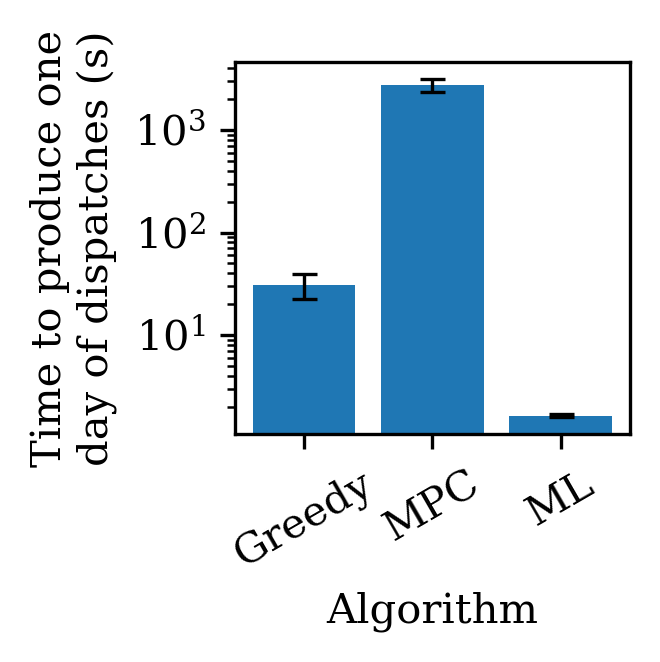

In [25]:
from matplotlib.ticker import MultipleLocator
greedy_times = np.load('data/greedy_times_wind={}.npy'.format(0))
model_times = np.load('data/model_times_winds={}.npy'.format(0))
lookahead_times = np.load('data/lookahead_times_new_w={}.npy'.format(6))

plt.figure(dpi=300, figsize=(2.3, 2.2))
plt.bar(['Greedy', 'MPC', 'ML'],
        [greedy_times.sum(axis=1).mean(), lookahead_times.sum(axis=1).mean(), model_times.mean()],
        yerr=[greedy_times.sum(axis=1).std(), lookahead_times.sum(axis=1).std(), model_times.std()],
        error_kw=dict(lw=0.8, capsize=3, capthick=0.8))

plt.yscale('log')
plt.xlabel('Algorithm')
plt.ylabel('Time to produce one\nday of dispatches (s)')
plt.tick_params(axis='y', which='minor')
plt.tick_params(axis='x', labelrotation=30)
plt.tight_layout()
plt.savefig('figures/times.pdf')

Define the switching algorithm to obtain guarantees with respect to both the ML and greedy algorithms

In [59]:
def rc_switch(ml_traj, greedy_traj, ambient_traj, eps, delta):

    Diam = ((inputs_table.loc['GT1_PWR', 'max'] - inputs_table.loc['GT1_PWR', 'min'])
            + (inputs_table.loc['GT2_PWR', 'max'] - inputs_table.loc['GT2_PWR', 'min'])
            + (inputs_table.loc['GT3_PWR', 'max'] - inputs_table.loc['GT3_PWR', 'min'])
            + (inputs_table.loc['ST_PWR', 'max'] - inputs_table.loc['ST_PWR', 'min']))

    # define the common starting point of both trajectories as zero
    rc_switch_dispatches = [np.zeros(8), ml_traj[0]]
    ml_cost = reduced_one_step_cost(ml_traj[0], np.zeros(8), ambient_traj[0], ramp_penalty=ramp_coeff, penalty=10)
    greedy_cost = reduced_one_step_cost(greedy_traj[0], np.zeros(8), ambient_traj[0], ramp_penalty=ramp_coeff, penalty=10)
    rc_switch_cost = ml_cost

    # binary state indicating whether algorithm is at ADV or ROB
    # ADV = 1, ROB = 0; always start with ADV
    state = 1
    buffer = ml_cost
    for t in range(1, ml_traj.shape[0]):
        ml_inst_cost = reduced_one_step_cost(ml_traj[t], ml_traj[t-1], ambient_traj[t], ramp_penalty=ramp_coeff, penalty=10)
        greedy_inst_cost = reduced_one_step_cost(greedy_traj[t], greedy_traj[t-1], ambient_traj[t], ramp_penalty=ramp_coeff, penalty=10)
        # update the cost aggregators
        ml_cost += ml_inst_cost
        buffer += ml_inst_cost
        greedy_cost += greedy_inst_cost

        if state and buffer >= 2*Diam/eps and greedy_cost < delta*ml_cost:
            state = 0
            buffer = 0.
            rc_switch_dispatches.append(greedy_traj[t])
        elif not state and greedy_cost < delta*ml_cost:
            rc_switch_dispatches.append(greedy_traj[t])
        elif not state and greedy_cost >= delta*ml_cost:
            state = 1
            rc_switch_dispatches.append(ml_traj[t])
        else:
            rc_switch_dispatches.append(ml_traj[t])

        rc_switch_cost += reduced_one_step_cost(rc_switch_dispatches[-1], rc_switch_dispatches[-2], ambient_traj[t], ramp_penalty=ramp_coeff, penalty=10)
    return rc_switch_dispatches, rc_switch_cost, ml_cost, greedy_cost

Evaluate the performance of the ``rc_switch`` algorithm in the face of distribution shift

In [110]:
n_epsilon = 10
epsilons = np.linspace(0.1, 1, n_epsilon)
rc_switch_costs_dist_shift = {}
ml_costs_dist_shift = {}
greedy_costs_dist_shift = {}
for sigma in tqdm(sigmas):
    rc_switch_costs = np.zeros((n_traj_experiment, n_epsilon))
    ml_costs = np.zeros((n_traj_experiment, n_epsilon))
    greedy_costs = np.zeros((n_traj_experiment, n_epsilon))
    greedy_dispatches = np.load('data/greedy_dispatches_wind={}.npy'.format(0))
    for i in tqdm(range(n_traj_experiment)):
        for j in range(n_epsilon):
            rc_switch_dispatches, rc_switch_cost, ml_cost, greedy_cost = rc_switch(model_dispatches_dist_shift[sigma][i], greedy_dispatches[i], dfs_train_winds[0][i, :, :5], eps=epsilons[j], delta=epsilons[j])
            rc_switch_costs[i, j] = rc_switch_cost
            ml_costs[i, j] = ml_cost
            greedy_costs[i, j] = greedy_cost
    rc_switch_costs_dist_shift[sigma] = rc_switch_costs
    ml_costs_dist_shift[sigma] = ml_costs
    greedy_costs_dist_shift[sigma] = greedy_costs

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

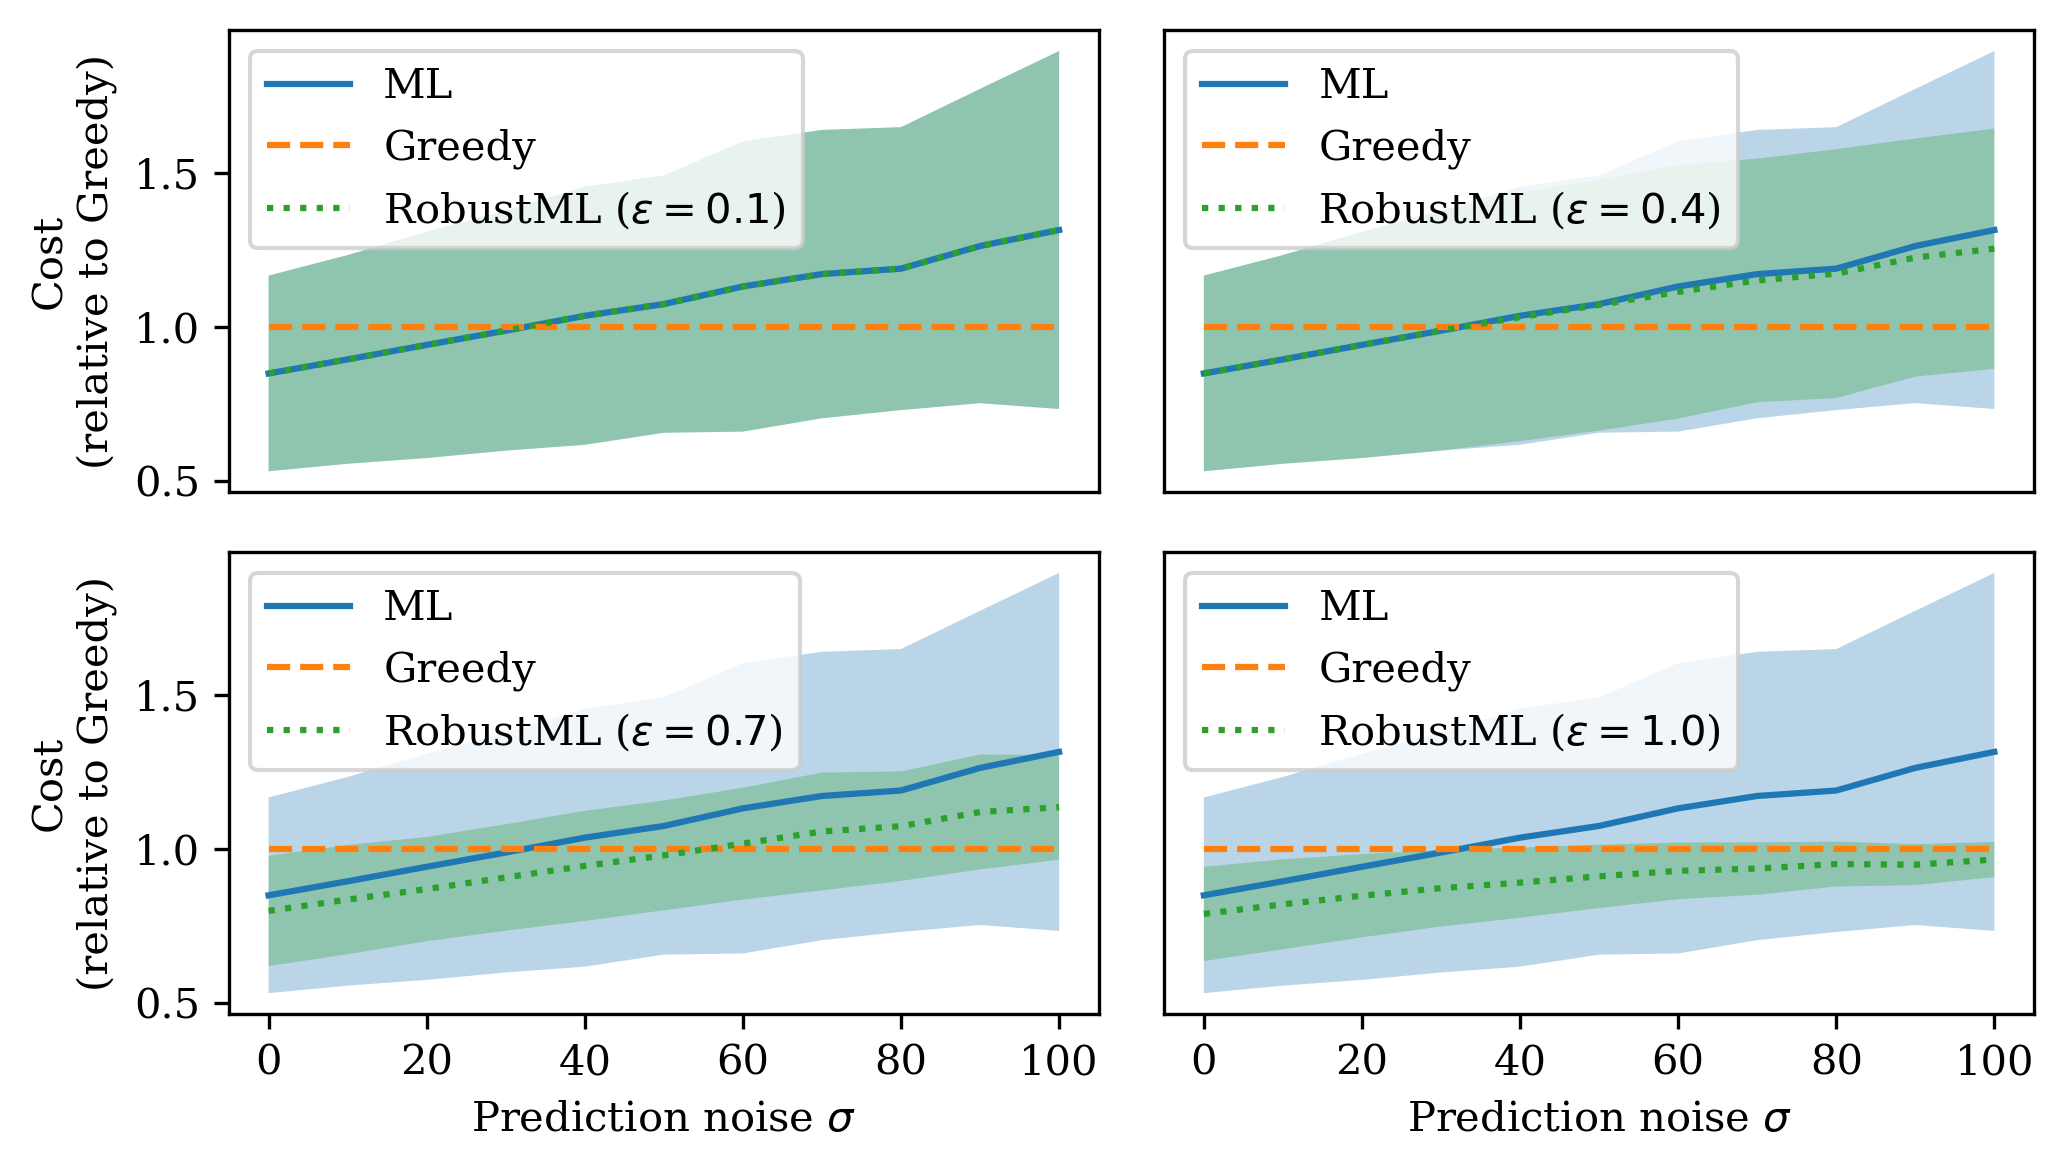

In [126]:
greedy_costs_dist_shift_array = np.array([greedy_costs_dist_shift[sigma] for sigma in sigmas])
ml_costs_dist_shift_array = np.array([ml_costs_dist_shift[sigma] for sigma in sigmas]) / greedy_costs_dist_shift_array
rc_switch_costs_dist_shift_array = np.array([rc_switch_costs_dist_shift[sigma] for sigma in sigmas]) / greedy_costs_dist_shift_array
greedy_costs_dist_shift_array /= greedy_costs_dist_shift_array 
    
# rewrite the prior code, but putting the plots for each i in 2x2 subplots grid
fig, axs = plt.subplots(2, 2, dpi=300, figsize=(7, 4))
for i, inds in zip([0, 3, 6, 9], [(0, 0), (0, 1), (1, 0), (1, 1)]):
    axs[inds].plot(sigmas, ml_costs_dist_shift_array[:, :, i].mean(axis=1), label='ML')
    axs[inds].fill_between(sigmas, ml_costs_dist_shift_array[:, :, i].mean(axis=1) - ml_costs_dist_shift_array[:, :, i].std(axis=1),
                    ml_costs_dist_shift_array[:, :, i].mean(axis=1) + ml_costs_dist_shift_array[:, :, i].std(axis=1), alpha=0.3)
    axs[inds].plot(sigmas, greedy_costs_dist_shift_array[:, :, i].mean(axis=1), label='Greedy', linestyle='dashed')
    axs[inds].fill_between(sigmas, greedy_costs_dist_shift_array[:, :, i].mean(axis=1) - greedy_costs_dist_shift_array[:, :, i].std(axis=1),
                    greedy_costs_dist_shift_array[:, :, i].mean(axis=1) + greedy_costs_dist_shift_array[:, :, i].std(axis=1), alpha=0.3)
    axs[inds].plot(sigmas, rc_switch_costs_dist_shift_array[:, :, i].mean(axis=1), label='RobustML ($\\epsilon = {}$)'.format(round(epsilons[i], 1)), linestyle='dotted')
    axs[inds].fill_between(sigmas, rc_switch_costs_dist_shift_array[:, :, i].mean(axis=1) - rc_switch_costs_dist_shift_array[:, :, i].std(axis=1),
                    rc_switch_costs_dist_shift_array[:, :, i].mean(axis=1) + rc_switch_costs_dist_shift_array[:, :, i].std(axis=1), alpha=0.3)
    if inds[0] == 1:
        axs[inds].set_xlabel('Prediction noise $\sigma$')
    else:
        axs[inds].set_xticks([])
    # plt.xticks(np.linspace(0, 2, 5))
    if inds[1] == 0:
        axs[inds].set_ylabel('Cost\n(relative to Greedy)')
    else:
        axs[inds].set_yticks([])
    axs[inds].legend()
plt.tight_layout()
plt.savefig('figures/distribution_shift.pdf')

Now evaluate the performance of ``rc_switch`` in the face of increased wind penetration.

In [133]:
n_epsilon = 4
epsilons = np.linspace(0.1, 1, n_epsilon)
rc_switch_costs_winds = {}
ml_costs_winds = {}
greedy_costs_winds = {}
for wind in [0, 100, 200, 300, 400]:
    rc_switch_costs = np.zeros((n_traj_experiment, n_epsilon))
    ml_costs = np.zeros((n_traj_experiment, n_epsilon))
    greedy_costs = np.zeros((n_traj_experiment, n_epsilon))
    greedy_dispatches = np.load('data/greedy_dispatches_wind={}.npy'.format(wind))
    for i in tqdm(range(n_traj_experiment)):
        for j in range(n_epsilon):
            rc_switch_dispatches, rc_switch_cost, ml_cost, greedy_cost = rc_switch(model_dispatches_winds[wind][i], greedy_dispatches[i], dfs_train_winds[wind][i, :, :5], eps=epsilons[j], delta=epsilons[j])
            rc_switch_costs[i, j] = rc_switch_cost
            ml_costs[i, j] = ml_cost
            greedy_costs[i, j] = greedy_cost
    rc_switch_costs_winds[wind] = rc_switch_costs
    ml_costs_winds[wind] = ml_costs
    greedy_costs_winds[wind] = greedy_costs

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

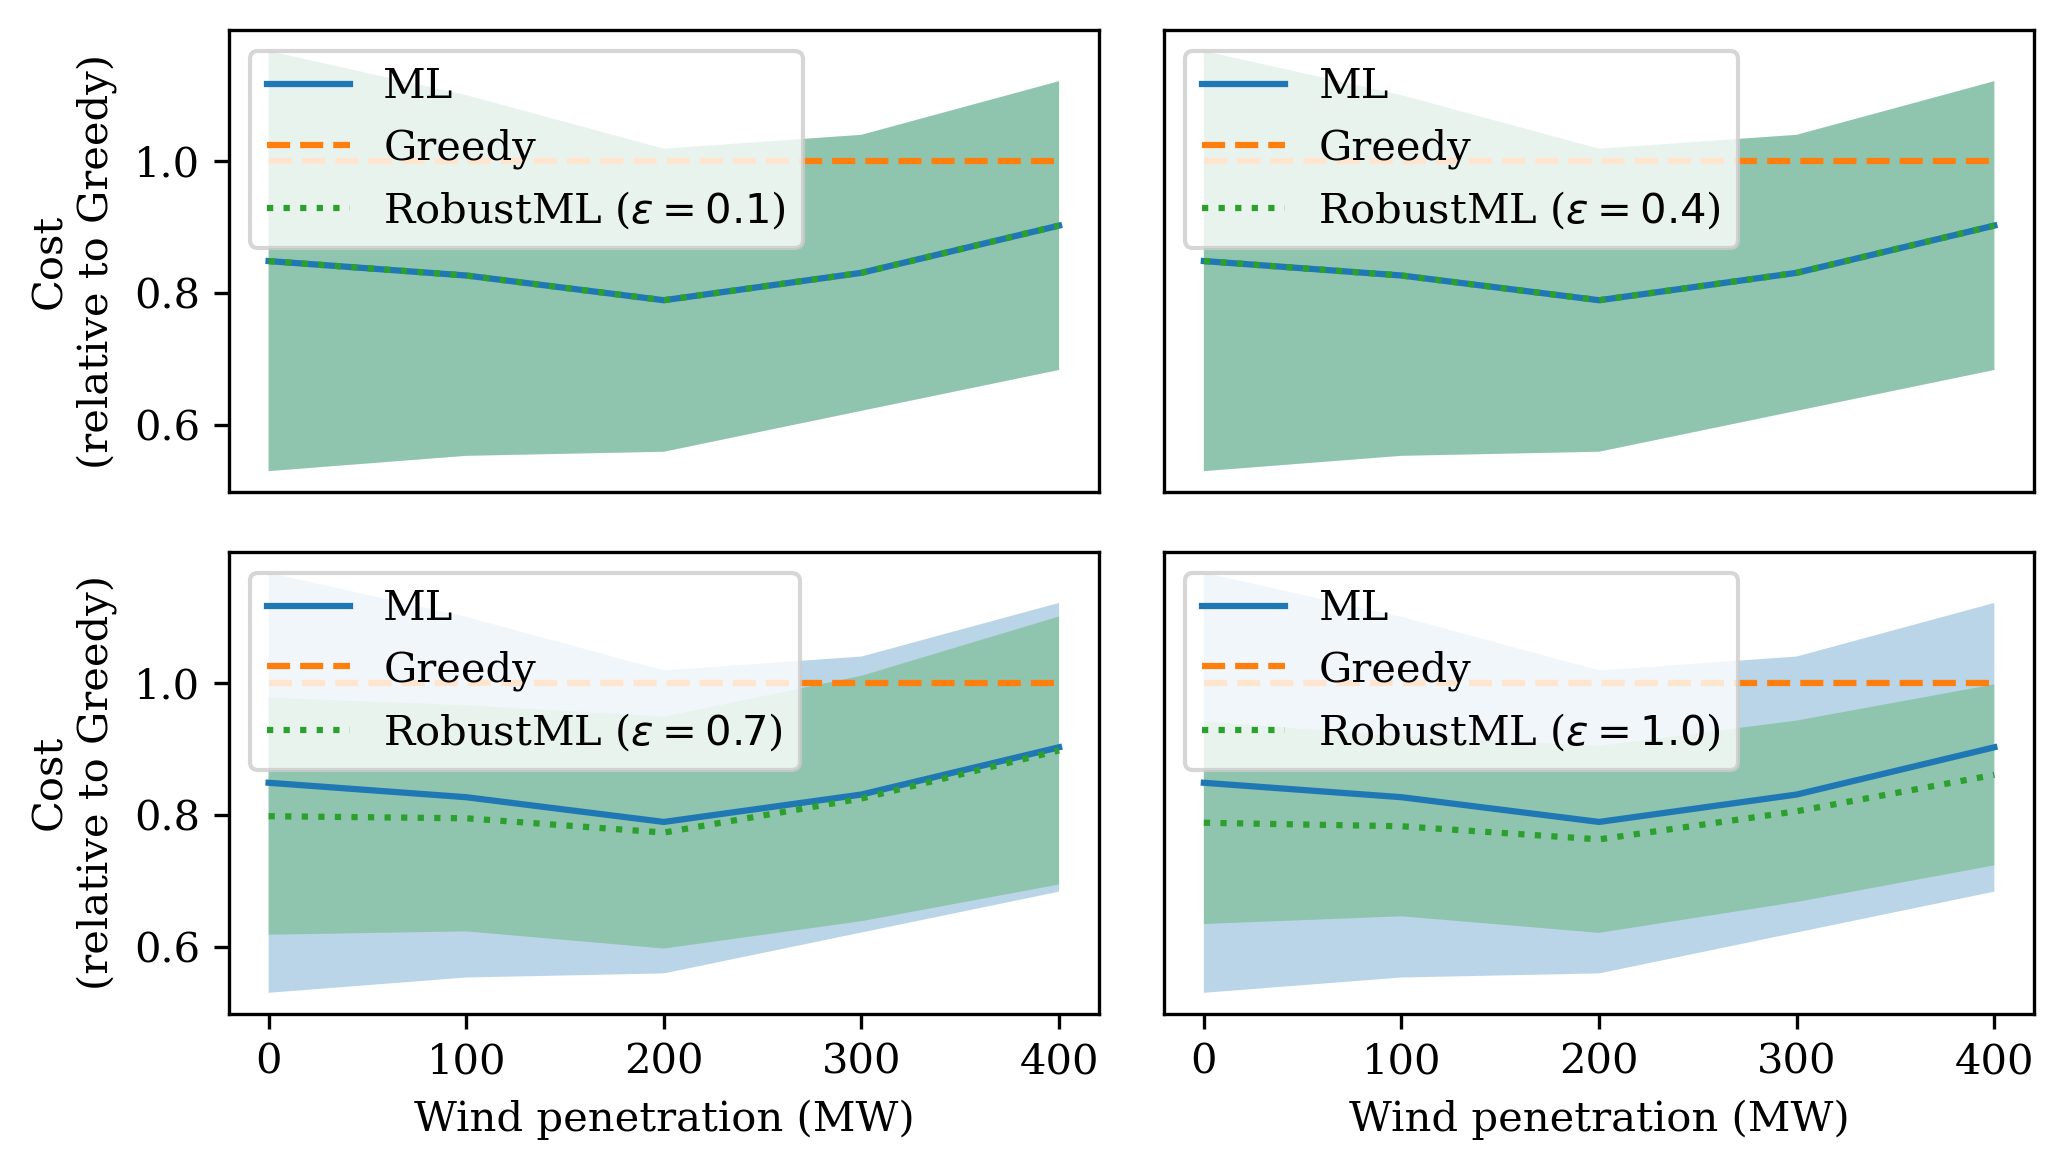

In [134]:
greedy_costs_winds_array = np.array([greedy_costs_winds[wind] for wind in [0, 100, 200, 300, 400]])
ml_costs_winds_array = np.array([ml_costs_winds[wind] for wind in [0, 100, 200, 300, 400]]) / greedy_costs_winds_array
rc_switch_costs_winds_array = np.array([rc_switch_costs_winds[wind] for wind in [0, 100, 200, 300, 400]]) / greedy_costs_winds_array
greedy_costs_winds_array /= greedy_costs_winds_array

# Generate a similar 2x2 plot as for distribution shift, but this time for different wind penetrations on the x axis
fig, axs = plt.subplots(2, 2, dpi=300, figsize=(7, 4))
for i, inds in zip(range(4), [(0, 0), (0, 1), (1, 0), (1, 1)]):
    axs[inds].plot([0, 100, 200, 300, 400], ml_costs_winds_array[:, :, i].mean(axis=1), label='ML')
    axs[inds].fill_between([0, 100, 200, 300, 400], ml_costs_winds_array[:, :, i].mean(axis=1) - ml_costs_winds_array[:, :, i].std(axis=1),
                    ml_costs_winds_array[:, :, i].mean(axis=1) + ml_costs_winds_array[:, :, i].std(axis=1), alpha=0.3)
    axs[inds].plot([0, 100, 200, 300, 400], greedy_costs_winds_array[:, :, i].mean(axis=1), label='Greedy', linestyle='dashed')
    axs[inds].fill_between([0, 100, 200, 300, 400], greedy_costs_winds_array[:, :, i].mean(axis=1) - greedy_costs_winds_array[:, :, i].std(axis=1),
                    greedy_costs_winds_array[:, :, i].mean(axis=1) + greedy_costs_winds_array[:, :, i].std(axis=1), alpha=0.3)
    axs[inds].plot([0, 100, 200, 300, 400], rc_switch_costs_winds_array[:, :, i].mean(axis=1), label='RobustML ($\\epsilon = {}$)'.format(round(epsilons[i], 1)), linestyle='dotted')
    axs[inds].fill_between([0, 100, 200, 300, 400], rc_switch_costs_winds_array[:, :, i].mean(axis=1) - rc_switch_costs_winds_array
                    [:, :, i].std(axis=1), rc_switch_costs_winds_array[:, :, i].mean(axis=1) + rc_switch_costs_winds_array[:, :, i].std(axis=1), alpha=0.3)
    if inds[0] == 1:
        axs[inds].set_xlabel('Wind penetration (MW)')    
    else:
        axs[inds].set_xticks([])
    # plt.xticks(np.linspace(0, 2, 5))
    if inds[1] == 0:
        axs[inds].set_ylabel('Cost\n(relative to Greedy)')
    else:
        axs[inds].set_yticks([])
    axs[inds].legend()
plt.tight_layout()
plt.savefig('figures/wind_penetration.pdf')